# Digit Recognition 
# Abstract 

## 1. Introduction
In this project we created a program that can recognize hand-written digits using the k-nearest neighbors algorithm (KNN). 
We used two different MNIST data sets - one for training the KNN algorithm and one containing images to be recognized by KNN -
containing 60 000 and 10 000 images and their label, stating which digit the images show. 
Each image is a 28 * 28 pixel grayscale digit from 0 to 9 drawn, previously centered around their centers off mass. 
### KNN Algorithm
We used the KNN algorithm to predict the right digit. It calculates the distance of all training digits to the image to be recognized,
sorts them and picks the k training images with the lowest distance. The most frequent digit among them will be picked as 
prediction. So if k=7 the only the 7 nearest neighbours to the test image are used. Let us say 2 of these neighbours are
for the digit "5", 1 is for the digit "7" and 4 neighbors are for the digit "9", the predicted digit will be a "9"
### PCA
We also performed a principle component analysis (PCA) to reduce the dimensionality of all images. 
It does so by replacing the 784 dimensions of an image vector by n <= 784 principal components, each of them explaining a certain
amount of variance of the image. This results in both noise reduction and loss of information, but also speeds up the KNN 
because it gets less input data.



# 2. Import functions
The import statements below are necessary for running the later code cells. `%matplotlib inline` will draw the
calculated plots to this Jupyter Notebook. Most of these modules are self-written modules building themselves upon external
python packages, except numpy, which allows quick and specific array operations.

In [12]:
%matplotlib inline
%load_ext autoreload
from src import pca
from src import pickle_operations as pickle_io
from src import plot
from src import KNN_sklearn as knn_sklearn
from src import meta_digit_operations as meta_digit
from src import knn_clustering
from src import load_image_vectors
import numpy as np
print("finished import")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
finished import


# 3. Loading training and test images from MNIST dataset
The original MNIST dataset is split up into two binary files containing the images, and two binary files containing the labels, saying which digits are displayed on each image.
We use a preprocessed version of MNIST, where labels and images are merged, yielding a plain text file for training and test images (.csv) that was 
compressed (.csv.gz) for not exceeding github's upload size limit.
For further analyzing the MNIST dataset it is required to load them first.   

In [11]:
%autoreload 2
training_lists = load_image_vectors.load_gz('data/mnist_train.csv.gz')
test_lists = load_image_vectors.load_gz('data/mnist_test.csv.gz')
print("Successfully loaded image lists")


Successfully loaded image lists


# 4. Test for digit prediction
To see if the KNN algorithm works, the first ten test images are recognized and plotted with their prediction.
For k, a random number was chosen, which means a random numbers of nearest neighbors to the Test image are selected.
And that label from test list images that has the most neighbors to the tet image is the label for the predicted digit. 


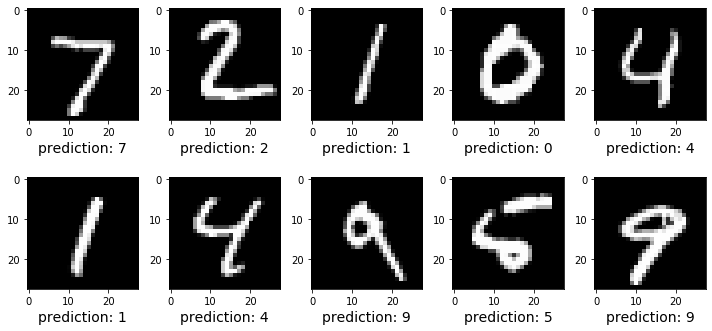

done


In [13]:
%autoreload 2
knn_sklearn.plot_sample_recognitions(training_lists, test_lists, 7)
print("done")


The plot shows that the KNN algorithm works well enough to accurately recognize a small set of images.


# 5. K accuracy test
In this step we try to determine the best amount of k-nearest neighbors we should use to have the most accurate prediction
possible. The function plots a bar chart for various k values and shows the percentage of correct digit predictions.
The plot shows that 3 is the optimal value for k. That means for k=3 neighbours our KNN algorithm predicts the right digit with around 97% accuracy.
It is not suggested to calculate the accuracies on runtime because it will take too much time. That's why the precalculated
accuracies are loaded and plotted. 

The differences in accuracy can be explained because even values for k are inferior. In case of a tie between two digits, the prediction is chosen randomly between them.
If k is chosen too big, there is a risk that digits with too much distance are included. 



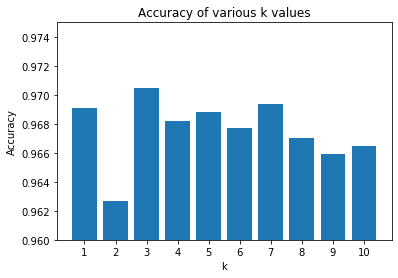

finished pca_variance_analysis


In [9]:
# runs the k_accuracy test with 10000 images between the chosen k values (k_min, k_max) > then plots the result
# plot.k_accuracy_test(training_lists, test_lists, 1, 4)  # saves the result as k_accuracy2.dat
plot.plot_k_accuracy(pickle_io.load_pickles("src/k_accuracy.dat"))
print("finished pca_variance_analysis")
    

# 6. PCA variance analysis
The KNN algorithm, our core-function of the project, works as intended. The biggest drawback is the long computing duration.
Through Principal Component Analysis (PCA), running time can be reduced significantly while retaining a high accuracy.
The diagram shows the retained variance per principal components (called dimensions in this graph).
It can be seen that the first dimensions explain by far the highest variance while the last dimensions explain almost none.


Started pca_variance_analysis
done


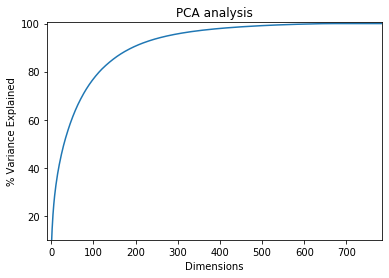

In [8]:
# runs the pca_variance_analysis and plots it
plot.pca_variance_analysis([csv_image.image for csv_image in test_lists])
print("done")


# 7. Plotted images with reduced dimensions
Since we were curious how the images look with reduced dimensions we plotted the images with 
reduced dimensions and compared them with the original digits.
This function plots the original image shown on the left side and on the right side the images with reduced dimensions.
The package scikit-learn provides a function that reconstructs images with the original amount of dimensions (784) from 
a dimension reduced image vector. As you can see the overall number is still visible but the pixels are bigger and also 
the pictures seem blurred. In addition the black background now is grey in the reduced images. Also interesting to see, 
is that there seems to be a black border around each digit and the grey background have different grey intensities compared
to each other. 

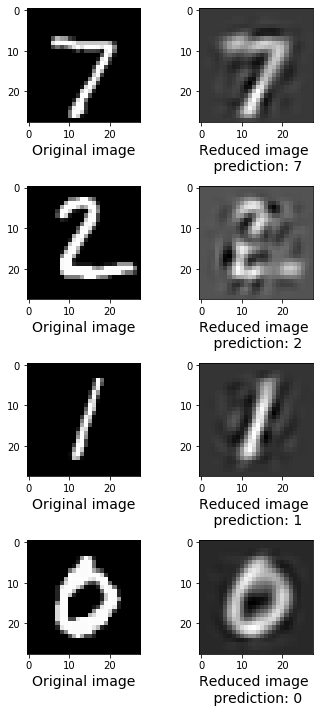

done


In [15]:
reduced_images = pca.reduce_dimensions([csv_image.image for csv_image in training_lists], 
                                       [csv_image.image for csv_image in test_lists], 100)
pca.plot_sample_reductions(reduced_images[2], training_lists, test_lists, reduced_images[0],  reduced_images[1], reduced_images[3], 100)
print("done")


# 8. Show an image reconstructed from a different number of dimensions
Next, too make sure our PCA is working fine and for experimental purposes, we try to see the results of the
PCA for different dimensions. S PCA is performed with 784 dimensions, thus keeping all variance, but rearranging them to principal components.
Then, reconstructed images are created from the first x principal components, thus making it obsolete to run the PCA once for
each subplot. 

PCA finished successfully
done


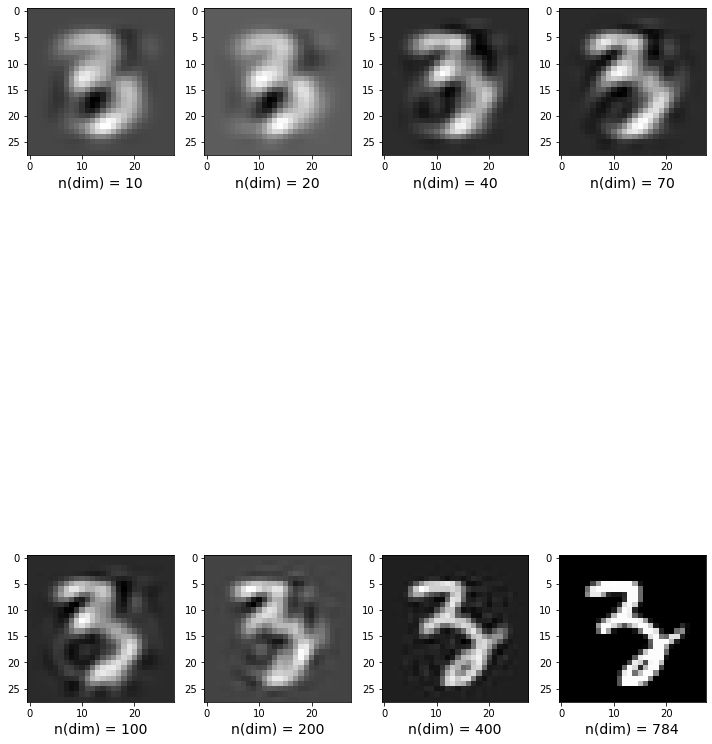

In [16]:
# Get reduces training and test images as tuple - reduced_images[0] is train_list, [1] is test_list without digits
reduced_images = pca.reduce_dimensions([csv_image.image for csv_image in training_lists],
                                        [csv_image.image for csv_image in test_lists], 784)
print("PCA finished successfully")
pca.plot_inverse_transforms(reduced_images[2], reduced_images[1], reduced_images[3])
print("done")

# PCA accuracy test
After that, the PCA variance is determined and plotted so we can find out the amount of dimensions necessary 
to have the highest accuracy to predict the right digit. The plot shows a slightly increased accuracy around n=78 compared
to a higher number of dimensions, which can be explained by noise reduction. Thus, for later PCA's n=78 will be used.

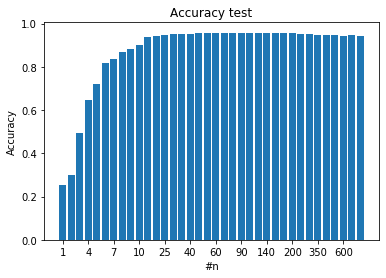

done


In [17]:
plot.plot_pca_accuracy(pickle_io.load_pickles("src/pca_accuracy.dat"))
print("done")


## Finding meta digits
Next, the objective is to obtain the best recognizable image for each digit.
For this, three different methods are used and later compared: the mean and the median of all intensity values for all
images of the same digit and the image that is surrounded by most images with the same digit.
Finding the meta digit allows evaluating digits and analyzing misrecognized images.

# Mean digit
Plots the most recognizable digit for each number from 1-10 by using the mean distance as for each pixel
from each digit with the same label.


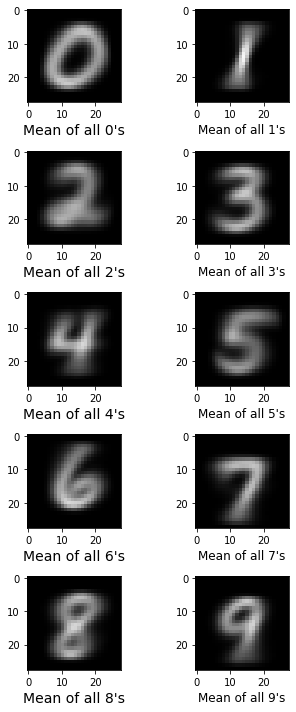

done


In [6]:
meta_digit.show_mean_digits(training_lists)
print("done")

## Median digit
Plots the images as in in the step before. But, this time uses the median distance instead of the mean distance.


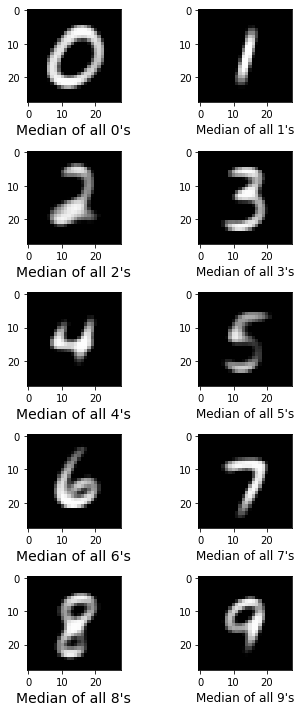

done


In [7]:
%autoreload 2
meta_digit.show_median_digits(training_lists)
print("done")

Next, the most clearly recognized images are calculated. For doing so, a KNN is run for all images of the same 
digit and k=500, the images with the highest amount of neighbors with the same digit are kept.

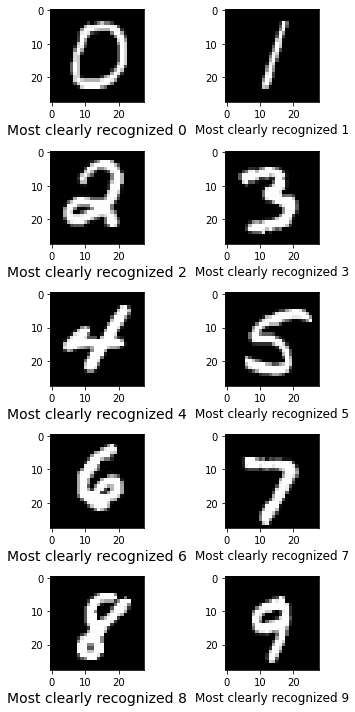

In [5]:
%autoreload 2
best_digits = np.asarray([csv_image.image for csv_image in meta_digit.get_best_digits(training_lists, test_lists)])
meta_digit.show_best_digits(training_lists, test_lists, best_digits)

The mean digits are blurrier than the MNIST images, because more pixels have an intensity >0, but most previously 
white pixels turn into gray. This fundamental difference makes mean digits much unlike than MNIST images.
The median digits are more or less binary images, mostly containing pure black and pure white values. Because 
many MNIST images of the same digit have different size, rotation or general shape, the median image has less white
pixels than MNIST images and thus loses part of the characteristics of those images and should be rejected.
The most clearly recognized image meanwhile is part of the MNIST dataset and can be well used for operations like the
KNN algorithm. It might have turned out into a slightly different one by altering k but is still good enough
for its purpose.


## Showing common mispredictions
Here, a heatmap is created, showing which digits are often confused with another one.
For speeding this up and using the effect of noise reduction, a PCA is run before.

In [ ]:
%autoreload 2
knn_clustering.get_mispredictions(training_lists, test_lists)
print("done")


If the digit was wrong predicted it is plotted to show what is wrong with the digit.

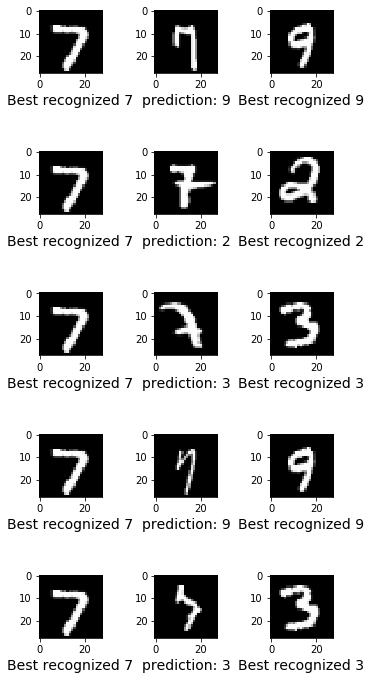

done


In [6]:
%autoreload 2
knn_sklearn.show_wrong_predicted(training_lists, test_lists, best_digits)
print("done")